In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
# 1.load datasets
data = pd.read_csv('dataset.csv')

In [3]:
# 2. پیش‌پردازش داده‌ها
# حذف ستون‌های غیر ضروری
data = data[['Voltage_measured (Volts)', 'Current_measured (Amps)', 'state', 'Time (secs)', 'Temperature_measured (C)']]



In [4]:
# تبدیل ویژگی state به one-hot encoding
data = pd.get_dummies(data, columns=['state'], drop_first=True)
# تبدیل state به مقدار float (0.0 یا 1.0)
data['state_discharge'] = data['state_discharge'].astype(float)


In [5]:
print(data[:4])

   Voltage_measured (Volts)  Current_measured (Amps)  Time (secs)  \
0                  3.210795                -0.001231        0.000   
1                  2.802418                -3.040619        2.516   
2                  3.371466                 1.508858        5.204   
3                  3.395449                 1.510285        7.672   

   Temperature_measured (C)  state_discharge  
0                 26.935337              0.0  
1                 26.936643              0.0  
2                 26.960100              0.0  
3                 26.976026              0.0  


In [6]:
# تقسیم داده‌ها به ویژگی‌ها و هدف
X = data.drop('Temperature_measured (C)', axis=1)
y = data['Temperature_measured (C)']


In [7]:
X_scaled = X.values  # بدون نرمال‌سازی

In [8]:
# تقسیم داده‌ها به مجموعه‌های آموزشی و آزمایشی
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 3. ساخت مدل شبکه عصبی
model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1)  # یک لایه خروجی برای پیش‌بینی دما
])
# 4. کامپایل و آموزش مدل
model.compile(optimizer='adam', loss='mean_squared_error')

In [19]:

history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/10
2603/2603 [==============================] - 2s 932us/step - loss: 0.7945 - val_loss: 0.6312
Epoch 2/10
2603/2603 [==============================] - 2s 913us/step - loss: 0.8388 - val_loss: 0.5676
Epoch 3/10
2603/2603 [==============================] - 2s 914us/step - loss: 0.7729 - val_loss: 0.6692
Epoch 4/10
2603/2603 [==============================] - 2s 921us/step - loss: 0.8896 - val_loss: 0.9153
Epoch 5/10
2603/2603 [==============================] - 2s 906us/step - loss: 0.7877 - val_loss: 0.5074
Epoch 6/10
2603/2603 [==============================] - 2s 922us/step - loss: 0.7597 - val_loss: 0.5526
Epoch 7/10
2603/2603 [==============================] - 2s 903us/step - loss: 0.7566 - val_loss: 1.9627
Epoch 8/10
2603/2603 [==============================] - 2s 904us/step - loss: 0.7974 - val_loss: 2.0750
Epoch 9/10
2603/2603 [==============================] - 2s 901us/step - loss: 0.7495 - val_loss: 0.5695
Epoch 10/10
2603/2603 [==============================] - 2s 915u

In [20]:
# 5. ارزیابی مدل
loss = model.evaluate(X_test, y_test)
print(f'Loss: {loss}')


651/651 [==============================] - 0s 657us/step - loss: 0.5981
Loss: 0.5981221199035645


In [21]:
# 6. پیش‌بینی دما و مقایسه با مقادیر واقعی
y_pred = model.predict(X_test)

651/651 [==============================] - 0s 612us/step


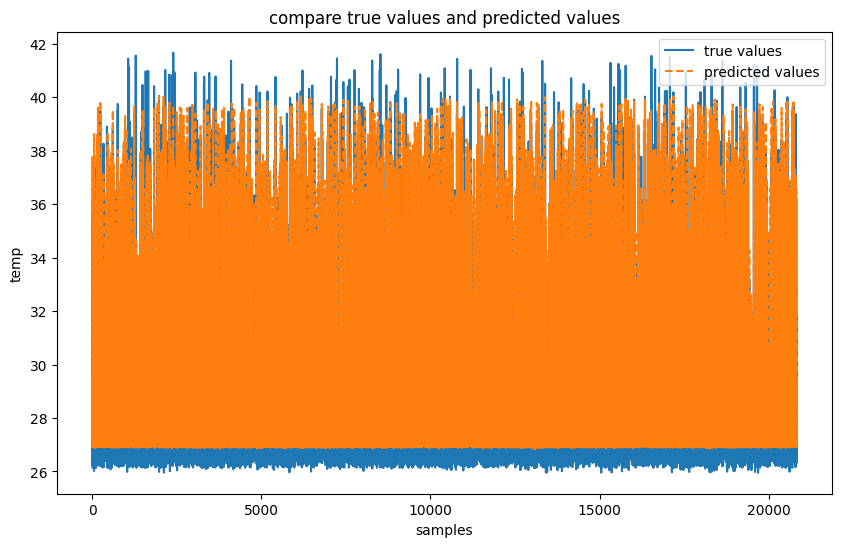

In [22]:
# 7. ترسیم نمودار مقایسه‌ای
plt.figure(figsize=(10,6))
plt.plot(y_test.values, label='true values',)
plt.plot(y_pred, label="predicted values", linestyle='--')
plt.xlabel('samples')
plt.ylabel('temp')
plt.legend()
plt.title("compare true values and predicted values")
plt.show()

In [23]:
# 8. آنالیز کلی
mse = np.mean((y_pred - y_test.values) ** 2)
print(f'Mean Squared Error (MSE): {mse}')

Mean Squared Error (MSE): 14.686597825884036


In [29]:
# مدل را به TFLite تبدیل کنید
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\mi\AppData\Local\Temp\tmplixs92pi\assets


INFO:tensorflow:Assets written to: C:\Users\mi\AppData\Local\Temp\tmplixs92pi\assets


In [25]:
interpreter = tf.lite.Interpreter(model_path="model.tflite")
interpreter.allocate_tensors()

# نمایش لیست تمام عملیات‌های مدل
print("TensorFlow Lite Ops in model:")
for op in interpreter._get_ops_details():
    print(op)


TensorFlow Lite Ops in model:
{'index': 0, 'op_name': 'FULLY_CONNECTED', 'inputs': array([0, 4, 3]), 'outputs': array([7])}
{'index': 1, 'op_name': 'FULLY_CONNECTED', 'inputs': array([7, 5, 1]), 'outputs': array([8])}
{'index': 2, 'op_name': 'FULLY_CONNECTED', 'inputs': array([8, 6, 2]), 'outputs': array([9])}
{'index': 3, 'op_name': 'DELEGATE', 'inputs': array([0, 1, 2, 3, 4, 5, 6]), 'outputs': array([9])}


In [28]:
# بارگذاری مدل TFLite
interpreter = tf.lite.Interpreter(model_path="model.tflite")
interpreter.allocate_tensors()

# دریافت اطلاعات ورودی و خروجی مدل
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# بارگذاری دیتاست از CSV
data = pd.read_csv("test_data.csv")

# حذف ستون‌های غیر ضروری
data = data[['Voltage_measured (Volts)', 'Current_measured (Amps)', 'state', 'Time (secs)']]

data = pd.get_dummies(data, columns=['state'], drop_first=True)
# تبدیل state به مقدار float (0.0 یا 1.0)
data['state_discharge'] = data['state_discharge'].astype(float)

X_scaled = data.values  # استفاده از داده‌های اصلی بدون نرمال‌سازی


# پردازش داده‌ها و ارسال به مدل
for i in range(100):
    input_data = np.array(X_scaled[i], dtype=np.float32).reshape(1, -1)

    # تنظیم مقدار ورودی مدل
    interpreter.set_tensor(input_details[0]['index'], input_data)

    # اجرای مدل
    interpreter.invoke()

    # دریافت مقدار پیش‌بینی‌شده
    predicted_temperature = interpreter.get_tensor(output_details[0]['index'])[0][0]
    # نمایش مقدار پیش‌بینی‌شده
    print(f"Sample {i+1}: Predicted Temperature = {predicted_temperature:.2f}")
    

Sample 1: Predicted Temperature = 27.07
Sample 2: Predicted Temperature = 26.57
Sample 3: Predicted Temperature = 27.52
Sample 4: Predicted Temperature = 27.58
Sample 5: Predicted Temperature = 27.61
Sample 6: Predicted Temperature = 27.63
Sample 7: Predicted Temperature = 27.65
Sample 8: Predicted Temperature = 27.66
Sample 9: Predicted Temperature = 27.67
Sample 10: Predicted Temperature = 27.68
Sample 11: Predicted Temperature = 27.68
Sample 12: Predicted Temperature = 27.69
Sample 13: Predicted Temperature = 27.69
Sample 14: Predicted Temperature = 27.69
Sample 15: Predicted Temperature = 27.70
Sample 16: Predicted Temperature = 27.70
Sample 17: Predicted Temperature = 27.69
Sample 18: Predicted Temperature = 27.69
Sample 19: Predicted Temperature = 27.69
Sample 20: Predicted Temperature = 27.69
Sample 21: Predicted Temperature = 27.68
Sample 22: Predicted Temperature = 27.67
Sample 23: Predicted Temperature = 27.67
Sample 24: Predicted Temperature = 27.66
Sample 25: Predicted Temp